# Exercise 3

In [1]:
import networkx as nx
from copy import deepcopy
import random
from pprint import pprint
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
E = {
	"o'":{
		'o':1,
	},
	'o':{
		'a':2/3,
		'b':1/3
	},
	'a':{
		'b':1/4,
		'c':1/4,
		'd':2/4
	},
	'b':{
		'c':1
	},
	'c':{
		'd':1
	},
	'd':{
		"d'":1
	},
	"d'":{
		"d'":1
	}
}

In [3]:
DG = nx.DiGraph()
edge_list = [(u,v,w) for u,e in E.items() for v,w in e.items()]
DG.add_weighted_edges_from(edge_list)

In [4]:
W = nx.adjacency_matrix(DG).toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
indices = dict()
for i in range(len(DG.nodes)):
    indices[list(DG.nodes)[i]] = i

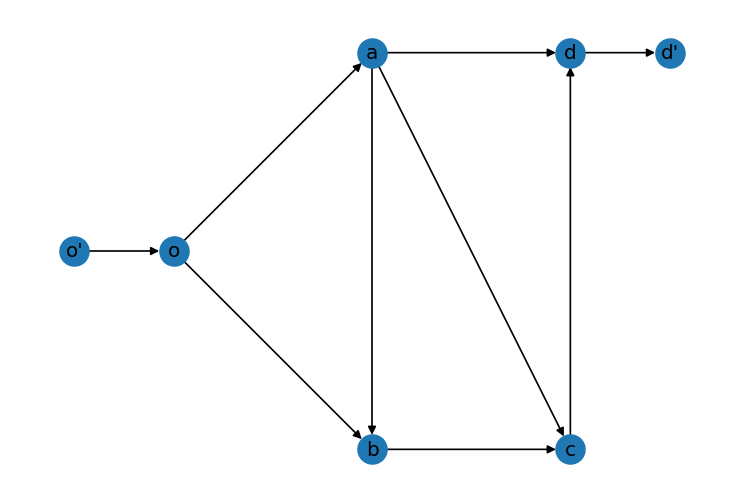

In [5]:
pos = {
	"o'":[-1,-1],
    'o':[0,-1],
    'a':[2,0],
    'b':[2,-2],
    'd':[4,0],
	'c':[4,-2],
	"d'":[5,0]
}
plt.figure(dpi=120)
nx.draw(DG, pos, with_labels=True)
try:
	os.mkdir('fig')
except:
	pass
plt.savefig('fig/graph3.png')

In [6]:
ws = degrees.max()
P_ = W / ws
P_ -= np.diag(P_)
P_ += np.diag(1 - degrees/ws*(1-np.diag(P)))

In [7]:
# function that simulates a move and returns destination
def move(P_, v):
	x = random.random()
	c = 0 # used to compute cumulative distribution
	for u,w in enumerate(list(P_[v])):
		c += w
		if x <= c: # lower bound found
			return u
	return u

In [8]:
def particle_distribution(P_, ws, indices, input_rate=1, fixed_rate=False, o="o'", d="d'", sim_time=60):
	o = indices[o]
	d = indices[d]
	choices = range(len(P_)) # node indices
	n = np.array([0]*len(P_)) # number of particles per node
	n[o] = input_rate
	res = [n.copy()] # number of particles per node for each time when a clock ticks
	t = [0] # list of times when a clock ticks
	tt = 0 # time past during simulation
	n_part = input_rate # total number of particles that are moving (comprises the ones in o', that is fixed to the input rate, but not the ones in d')
	tt += random.expovariate(ws*n_part) # time to wait before moving from node
	while tt < sim_time:
		t.append(tt)
		if fixed_rate:
			r = (n>0).astype(int) 	# node's weight is 1 if there are particles in that node, 0 otherwise
			r[o] = n[o] 			# apart from o', because its rate is always the input rate
			rate = r.sum()
		else:
			r = n
			rate = n_part
		u = random.choices(choices, r, k=1)[0] # choose node from which move a particle, using values in r as priorities
		tt += random.expovariate(ws*rate) # time to wait before moving from node
		if u == o: # in this case a particle is moving from o' to o, so the number of particles inside the graph increases
			n_part += 1
		else: # in this case a particle is moving not from o', so I update the number of particles in u
			n[u] -= 1
		u = move(P_, u)
		if u == d: # in this case a particle is moving from d to d', so the number of particles inside the graph decreases
			n_part -= 1
		else: # in this case a particle is moving not to d', so I update the number of particles in u
			n[u] += 1
		res.append(n.copy())
	return t, np.array(res)


In [9]:
# function used to print things
def aprint(v, k=None):
	if k == None:
		print('[%s]'%(', '.join(f'{x:.2f}' for x in v)))
	else:
		print('{%s}'%(', '.join(f"'{kk}':{vv:.2f}" for kk,vv in zip(k,v))))

In [10]:
# function used to plot number of particles in nodes over time
def time_plot(t, v, labels, img, exclusions=[]):
	fig = plt.figure(dpi=200, figsize=(9,3))
	ax  = fig.add_subplot(111)
	ax.set_position([0.075,0.15,0.85,0.8])
	for l,i in zip(labels, range(v.shape[0])):
		if l not in exclusions:
			ax.plot(np.array(t), v[i,:].T, label=l, linewidth=0.8)
	ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
	ax.set_xlabel('time')
	ax.set_ylabel('number of particles')
	plt.savefig(f'fig/{img}.png')
	return fig

### Proportional rate

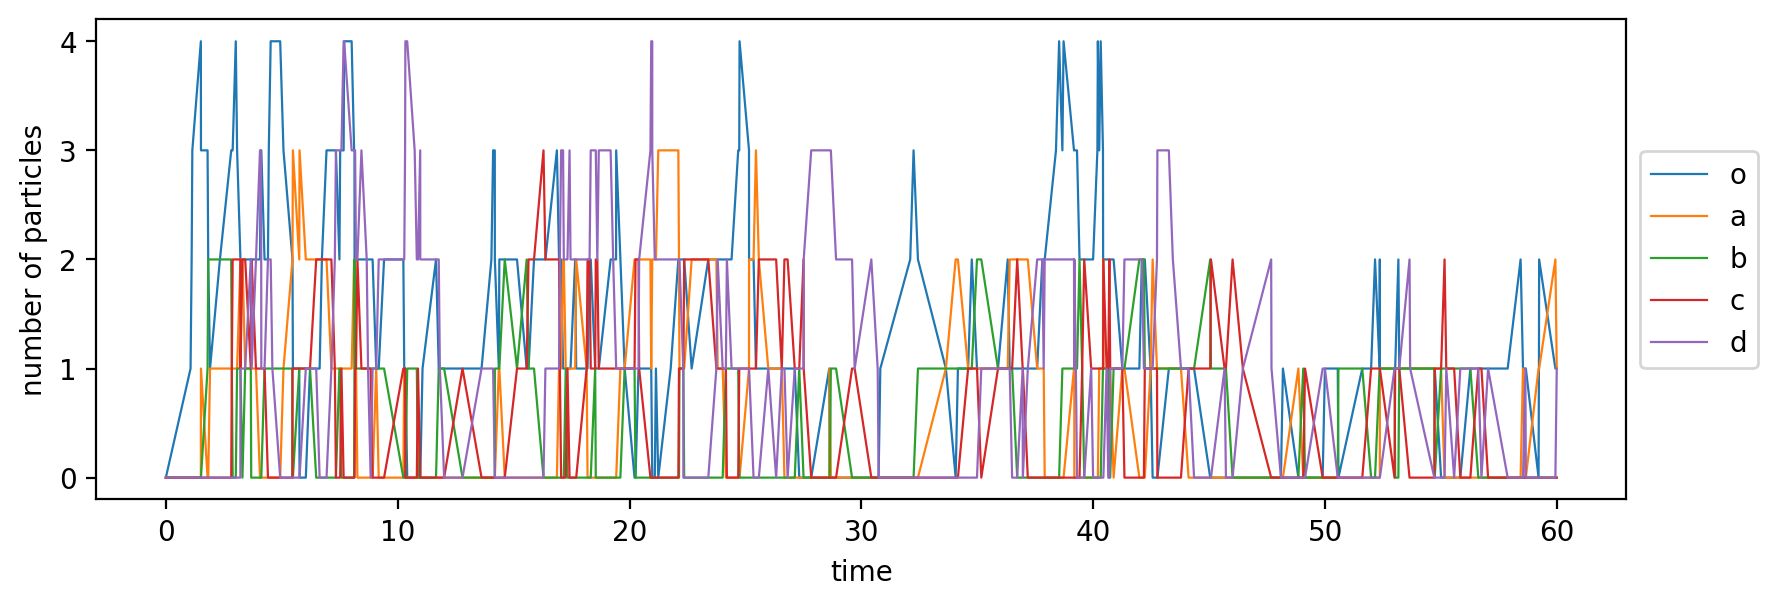

In [11]:
t, dd = particle_distribution(P_, ws, indices)
fig = time_plot(t, dd.T, indices.keys(), 'tp1', ["o'","d'"])

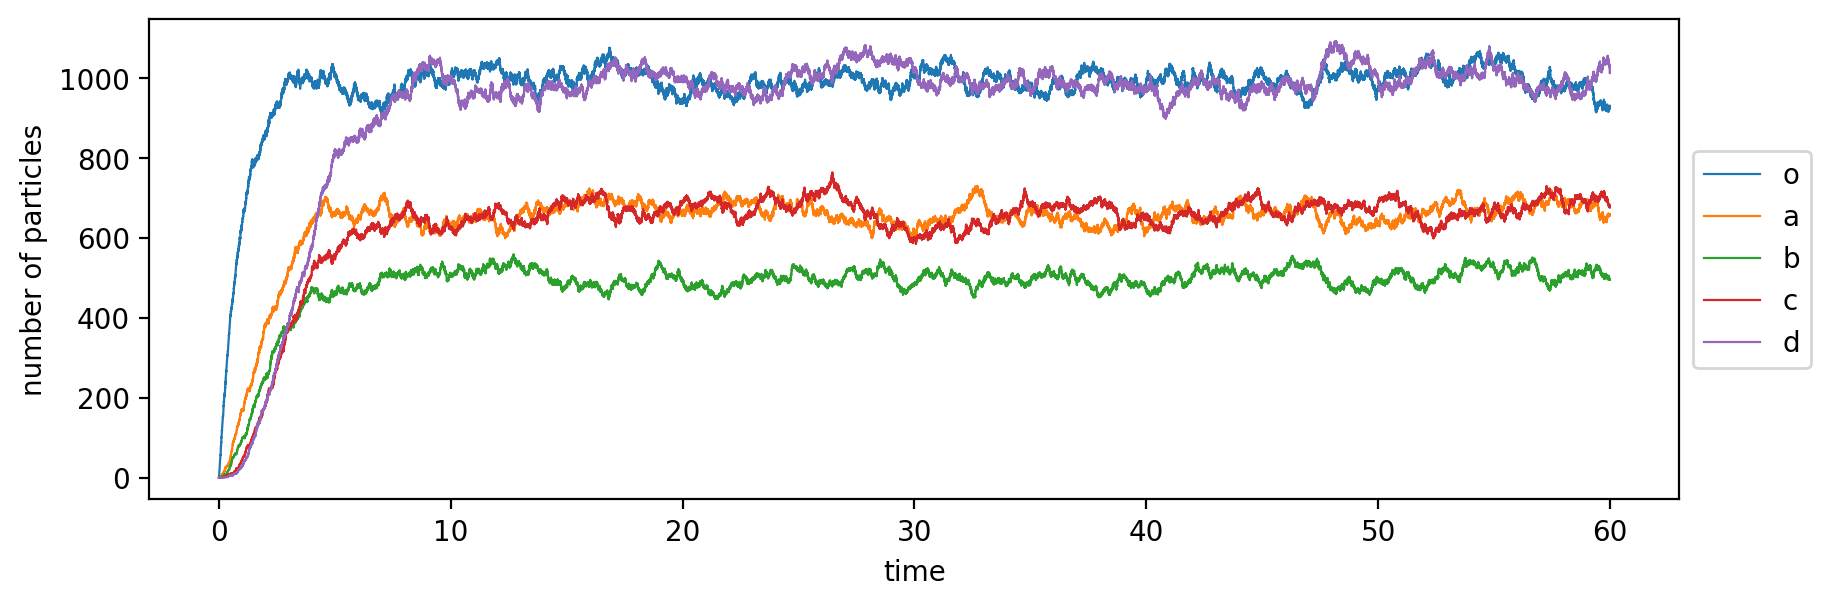

In [12]:
t, dd = particle_distribution(P_, ws, indices, input_rate=1000)
fig = time_plot(t, dd.T, indices.keys(), 'tp1000', ["o'","d'"])

The system can handle any input rate without blowing up, because the rate a node passes along particles is proportional to the number of particles in the node, so when there will be a great number of particles in the system, a lot of them will move from a node inside the graph and not from the input.\
More formally,
$$ \lim_{n \to +\infty} \dfrac{r_i}{r_g} = 0 $$
where $n$ is the number of particles in the system, $r_i$ is the input rate, $r_g$ is the sum of the rates of the nodes.

### Fixed rate

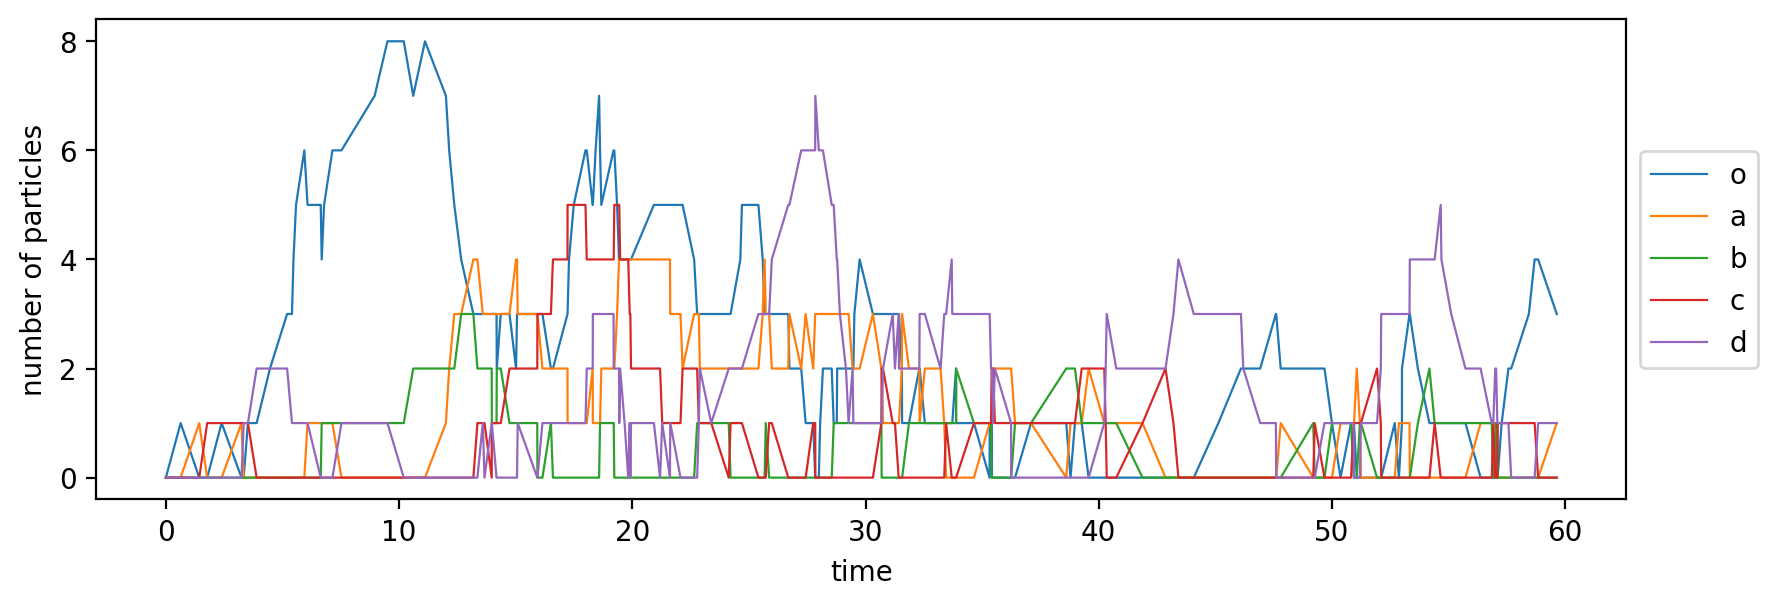

In [13]:
t, dd = particle_distribution(P_, ws, indices, fixed_rate=True)
fig = time_plot(t, dd.T, indices.keys(), 'tf1', ["o'","d'"])

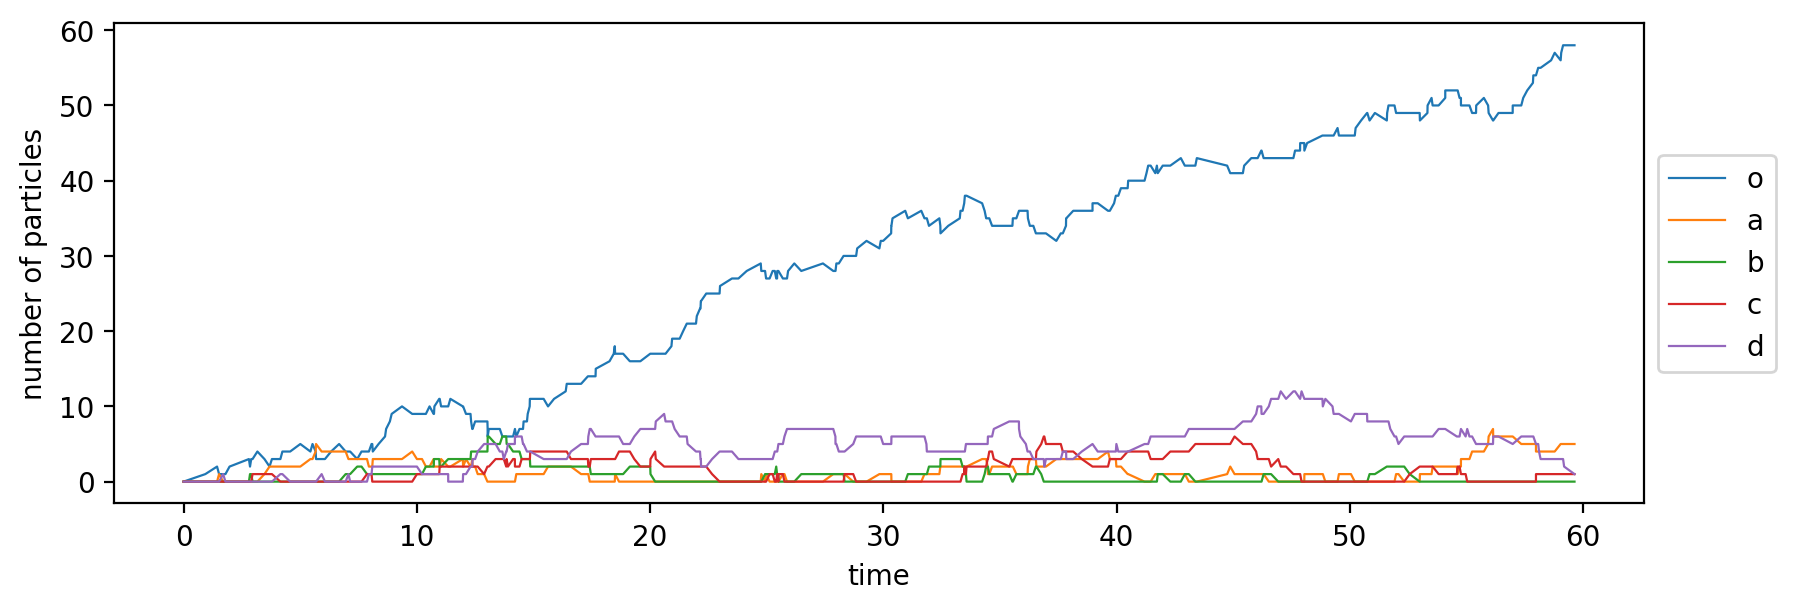

In [14]:
t, dd = particle_distribution(P_, ws, indices, fixed_rate=True, input_rate=2)
fig = time_plot(t, dd.T, indices.keys(), 'tf2', ["o'","d'"])

In this case, the system can handle an input rate of one particle per time unit, because the rate each node passes along particles is greater than or equal to the rate new particles are injected inside the graph, so particles won't stuck on any node.\
The system blows up for each input rate greater than one, because the rate of node $o$ would be smaller than the input rate, so particles will stuck on this node.